In [2]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

# For reproducible random results.
np.random.seed(789)

# The following utility functions are provided for your convenience.
# You may use them in your solution, or you may write your own.
# Do not alter them, and please read the docstrings carefully.
K = np.array([[471.14628085,  -4.94771211, 295.13159043], [0., 436.71106326, 240.96582594], [0., 0., 1.]])
SQUARE_SIZE = 0.0205

## Problem 1.1

[[409.75568  337.2855  ]
 [373.57596  332.3364  ]
 [339.7811   326.45688 ]
 [309.51093  322.09177 ]
 [280.6833   317.26987 ]
 [255.16408  313.46848 ]
 [230.38338  309.56683 ]
 [207.98701  306.05197 ]
 [185.57394  303.35287 ]
 [409.2101   301.41022 ]
 [372.34335  297.24222 ]
 [338.6659   293.5298  ]
 [307.65433  289.82336 ]
 [279.29675  286.6049  ]
 [253.26137  283.90213 ]
 [228.57938  280.8061  ]
 [206.30377  278.45425 ]
 [185.11617  275.81442 ]
 [410.2782   264.4523  ]
 [373.3293   262.04208 ]
 [338.55518  259.2217  ]
 [307.21747  257.4115  ]
 [278.45435  255.4521  ]
 [251.67528  253.59041 ]
 [226.95932  251.54459 ]
 [204.83652  249.93774 ]
 [183.45502  248.51535 ]
 [410.52704  226.43387 ]
 [373.34225  225.81647 ]
 [338.6454   224.6559  ]
 [306.46765  224.21144 ]
 [277.78802  223.55478 ]
 [250.60614  222.64636 ]
 [226.43892  222.11429 ]
 [203.53061  221.44954 ]
 [182.52428  220.57126 ]
 [411.51886  188.30602 ]
 [373.7152   189.27144 ]
 [338.43982  189.91966 ]
 [306.71164  190.71596 ]


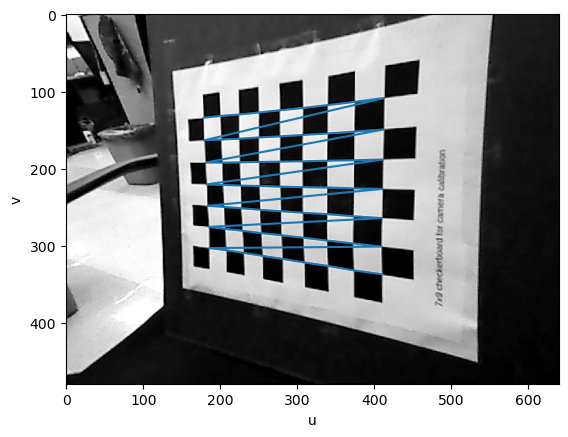

In [13]:
# Read the image from file
img_path = "p1_data/checkerboard.png"
image = cv2.imread(img_path, 0)

# Plot Corners on top of image
fig = plt.figure()
ax = plt.subplot()
ax.imshow(image, cmap="gray")
ax.set_ylabel("v")
ax.set_xlabel("u")

# 1) Find the corner locations of the chessboard in image space.
#    Hint: Use the function cv2.findChessboardCorners(image, (num_corners_x, num_corners_y))
#    Hint: findChessboardCorners outputs pixel coordinates!
# 2) Plot their location in image space over top of the image.
#    Hint: use ax.plot(...) -- should be one line!
#    Hint: This should only be 1 line of code!

ncorners_y = 7
ncorners_x = 9
# --------- YOUR CODE STARTS HERE ---------------
_, corners = cv2.findChessboardCorners(image, (ncorners_x, ncorners_y))
corners = corners.reshape((-1, 2))
ax.plot(corners[:, 0], corners[:, 1])
# --------- YOUR CODE ENDS HERE -----------------

## Problem 1.2

In [26]:
# 1)  Compute the homography, H.
#     1.a) Use the SQUARE_SIZE, and the dimensions of the grid above to
#             to create a the array P = [[X_0, Y_0, 1], .... [X_n, Y_n, 1]].
#             P should have shape (63, 3).
#          Hint: Use np.meshgrid to generate the X, Y coordinates, and
#             array.reshape and np.hstack to form the final matrix.
#     1.b) Form the M matrix outlined in the write-up!
#     1.c) Use np.linalg.svd(M) to solve for the nullspace of M and recover H.
#          Hint: np.linalg.svd(M) returns V.T.
#          Hint: Use <array>.reshape(3, 3) to give H the proper dimensions.
# 2)  Compute the camera pose rotation, R, and translation, t.
#     2.a) Compute KinvH = inv(K) @ H.
#          Hint: Use np.linalg.inv().
#     2.b) Normalize the values of KinvH to it's first column.
#          Hint: Use np.linalg.norm() and the / operator.
#     2.c) Compute r0, r1, r2, and t as outlined in the write-up.
#          Hint: Use np.cross().
#     2.d) Form R from r0, r1, and r2.
#          Hint: Use np.column_stack()

# --------- YOUR CODE STARTS HERE ---------------
#1.a
x = np.linspace(0, ncorners_x*SQUARE_SIZE, ncorners_x)
y = np.linspace(0, ncorners_y*SQUARE_SIZE, ncorners_y)
x_coord, y_coord = np.meshgrid(x, y)
x_coord = x_coord.reshape((-1, 1)) 
y_coord = y_coord.reshape((-1, 1))
P = np.hstack((x_coord, y_coord, np.ones((x_coord.shape[0], 1))))

#1.b
M = np.zeros((P.shape[0]*2, 9))
for i in range(P.shape[0]):
    X, Y, _ = P[i]
    u, v = corners[i]
    M[2*i, :] = np.array([-X, -Y, -1, 0, 0, 0, X*u, Y*u, u])
    M[2*i+1, :] = np.array([0, 0, 0, -X, -Y, -1, X*v, Y*v, v])
V = np.linalg.svd(M)[2]
H = V[-1].reshape((3, 3))
scale_pose = np.matmul(np.linalg.inv(K), H)
pose = scale_pose/np.linalg.norm(scale_pose[:, 0])
r0 = pose[:, 0]
r1 = pose[:, 1]
t = pose[:, 2]
r2 = np.cross(r0, r1)
R = np.column_stack((r0, r1, r2, t))
# --------- YOUR CODE ENDS HERE -----------------

[[ 0.84160193  0.02369708  0.53467804 -0.06796947]
 [ 0.04607157  0.9830854  -0.11597251 -0.06192732]
 [-0.53812973  0.12264753  0.8262748  -0.27941237]]


## Problem 1.3

Text(0, 0.5, 'v')

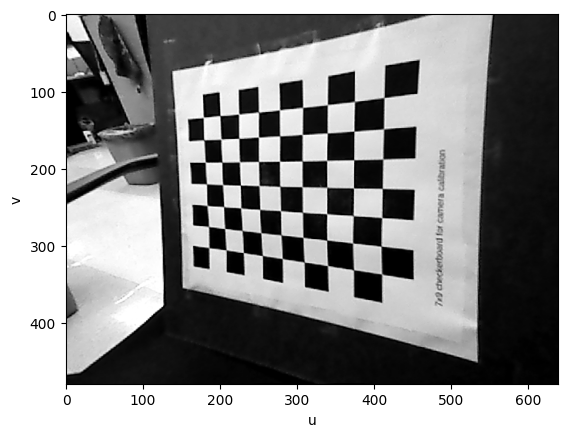

In [4]:
# 1) Finish the transform_world_to_camera function which uses
#       the given K, and the R and t that you calculated!.
#    Hint: You'll need to use some equations from the write-up.

def transform_world_to_camera(K, R, t, world_coords):
    """
    Args:
        K: np.array with shape (3, 3), camera intrinsics matrix.
        R: np.array with shape (3, 3), camera rotation.
        t: np.array with shape (3, ) or (3, 1), camera translation.
        world_coords: np.array with shape (N, 3), cartesian coordinates (X, Y, Z)
            in world frame to transform into camera pixel space.
    Return:
        uv: np.array with shape (N, 2), with (u, v) coordinates of that are
            the projections of the the world_coords on the image plane.
    """
    # --------- YOUR CODE STARTS HERE ---------------

    # --------- YOUR CODE ENDS HERE -----------------
    return uv

ax = plt.subplot()
ax.imshow(image, cmap="gray")
ax.set_xlabel("u")
ax.set_ylabel("v")

# 2) Project the global coordinates of the corners that you calculated
#       earlier back onto the image using transform_world_to_camera.
#    Hint: The input world_coords should have shape (63, 3)
#    Hint: Use the Xs and Ys you got earlier and set Zs = 0.
#    Hint: You may need to change some of the variable names at the bottom
#       of this cell to match the names that you used above!

# --------- YOUR CODE STARTS HERE ---------------

# --------- YOUR CODE ENDS HERE -----------------

## Project Anything!
Try using your the camera pose you computed to project our secret point cloud (defined in world coordinates) onto the camera frame!

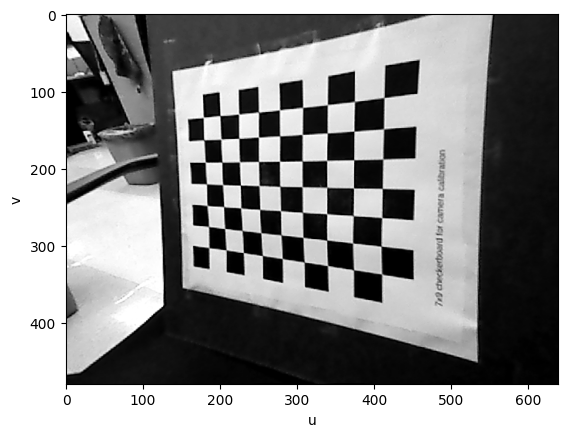

In [5]:
ax = plt.subplot()
ax.imshow(image, cmap="gray")
ax.set_xlabel("u")
ax.set_ylabel("v")

# Load the secrect point cloud from file!
point_cloud_secret = np.load("p1_data/secret.npy")

# NOTE: Uncomment the lines below when you've finished everything else!
# uv_secret = transform_world_to_camera(K, R, t, point_cloud_secret)
# ax.scatter(uv_secret[:, 0], uv_secret[:, 1], s=0.5, c="b")